In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from scipy.spatial import distance
from pyproj import Proj,transform
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy", towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")
#Calculate Euclidean distances using Haversine formula

# Put into Easting/northing coord (as in UK model)

In [2]:
def dfLLtoEN(df):
    """Returns easting, northing tuple
    """
    vlon36, vlat36 = transform(v84,v36,df["long"].values,df["lat"].values)
    result = vgrid(vlon36,vlat36)

    # Transform the output to a Dataframe
    eastnorth = pd.DataFrame(index=df.index)
    for i in result:
        eastnorth["Easting"] = result[0]
        eastnorth["Northing"] = result[1]

    return round(eastnorth)

# Get data

In [3]:
Path = '../StudyGroup/'
CompleteData=pd.read_csv(Path+"completeData2.csv",header = 0)
CompleteData = CompleteData.drop(columns = 'Unnamed: 0')

In [4]:
N = len(CompleteData)
CompleteData = CompleteData.rename(index=str, columns={'X__1': "study"})

In [5]:
CompleteData[['Easting', 'Northing']] = dfLLtoEN(CompleteData[['lat', 'long']])

In [6]:
xmax = np.max(CompleteData['Easting'].values)
xmin = np.min(CompleteData['Easting'].values)
ymax = np.max(CompleteData['Northing'].values)
ymin = np.min(CompleteData['Northing'].values)
sizex = xmax-xmin
sizey = ymax-ymin
CompleteData['xcoord'] = CompleteData['Easting'] - xmin
CompleteData['ycoord'] = CompleteData['Northing'] - ymin
xcoord = CompleteData['xcoord'].values
ycoord = CompleteData['ycoord'].values

In [7]:
joinedinput = np.column_stack((xcoord, ycoord))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

# I think divide by 1000 to get into Km - CHECK THIS!!!

In [8]:
dist = dist/1000 #into km

In [9]:
CompleteData.columns.values

array(['study', 'lat', 'long', 'cattle', 'sr', 'fmd', 'vaccine',
       'water_grazing', 'milk', 'equipment', 'vet', 'contact_animal',
       'contact_people', 'grazing', 'water', 'Easting', 'Northing',
       'xcoord', 'ycoord'], dtype=object)

# Plots to explore the data, notice each study is a different scale

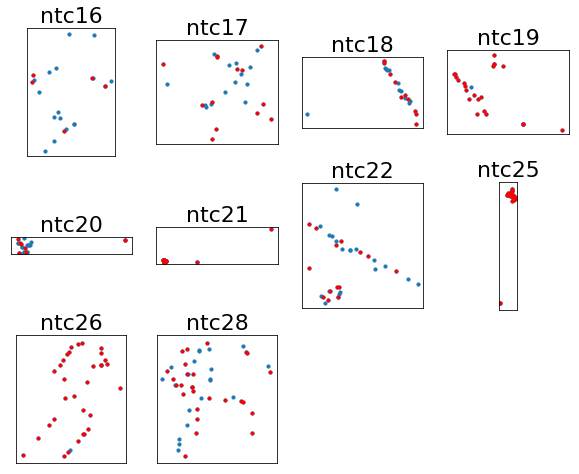

In [10]:
plt.figure(figsize = (10,8
            ))
#Plot spatial distribution of farms sharing water/grazing areas for each study
ind = 0
for index, value in enumerate(CompleteData['study'].unique()):
    stud = CompleteData[CompleteData['study']==value]
    if stud['lat'][stud['water_grazing'] == 1].empty == False:
        ind +=1
        plt.subplot(3,4, ind)
        plt.scatter(stud['xcoord'], stud['ycoord'], s = 10, label = 'location of farm')
        plt.scatter(stud['xcoord'][stud['water_grazing'] == 1], stud['ycoord'][stud['water_grazing'] == 1], c = 'red', s = 8, label = 'farm uses shared water')
        plt.title('{}'.format(value), fontsize = 22)
        plt.xticks([],[]) #anonymizing
        plt.yticks([],[]) #anonymizing
        plt.axis('scaled') #doesn't strech plots, disassort things
#         if index == 0:
# #             plt.legend(loc = 'lower center', fontsize = 18)

# All studies together

<IPython.core.display.Javascript object>


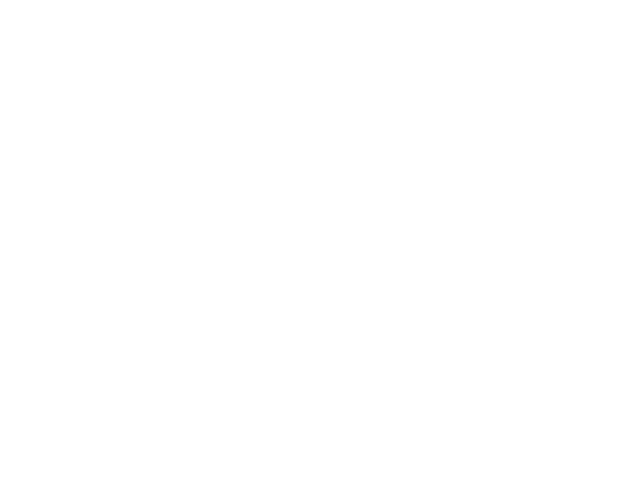

In [11]:
%matplotlib notebook
for index, value in enumerate(CompleteData['study'].unique()):
    stud = CompleteData[CompleteData['study']==value]
    plt.scatter(stud['xcoord'], stud['ycoord'], label = '{}'.format(value))
plt.legend(loc = 'upper left',ncol = 3)
plt.axis('scaled')
plt.xticks([],[])
plt.yticks([],[])
plt.show()


# histogram of distances between all farms in all studies

<IPython.core.display.Javascript object>


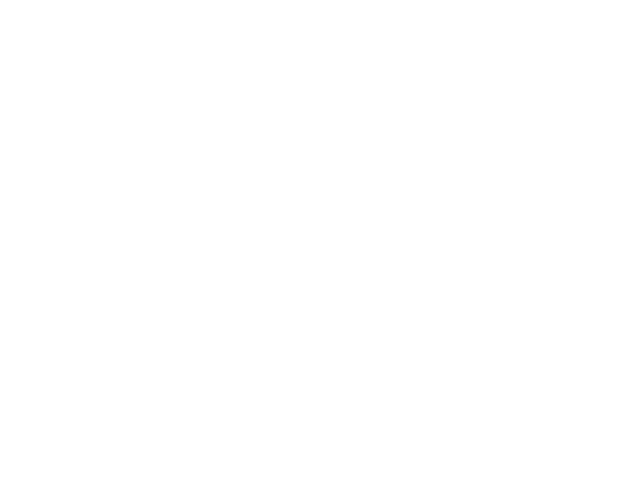

Text(0.5,1,'Distribution of distances between farms')

In [12]:
%matplotlib notebook
plt.hist((dist).flatten()[~np.isnan(dist.flatten())], bins = 40, normed = True)
plt.xlabel('km between farms')
plt.plot(4*np.ones(5), np.linspace(0,1, 5))
plt.ylim(0,0.06)
plt.title('Distribution of distances between farms')

# Interestingly for study 24, didn't predict any shared water or grazing

In [13]:
# plt.figure(figsize = (5,5))
#Plot spatial distribution of farms sharing water/grazing areas for each study
ind = 0
for index, value in enumerate(CompleteData['study'].unique()):
    stud = CompleteData[CompleteData['study']==value]
    if stud['lat'][stud['water_grazing'] == 1].empty:
        ind +=1
#         plt.subplot(2,3, ind)
        plt.scatter(stud['xcoord'], stud['ycoord'],s = 10, label = 'location of farm')
        plt.scatter(stud['xcoord'][stud['water_grazing'] == 1], stud['ycoord'][stud['water_grazing'] == 1], c = 'red', label = 'farm uses shared water')
        plt.title('{}'.format(value), fontsize = 22)
        plt.xticks([],[]) #anonymizing
        plt.yticks([],[]) #anonymizing
        plt.axis('scaled')
        if index == 0:
            plt.legend(loc = 'upper left', fontsize = 18)

# Plot of FMD in the last 6 months

<IPython.core.display.Javascript object>


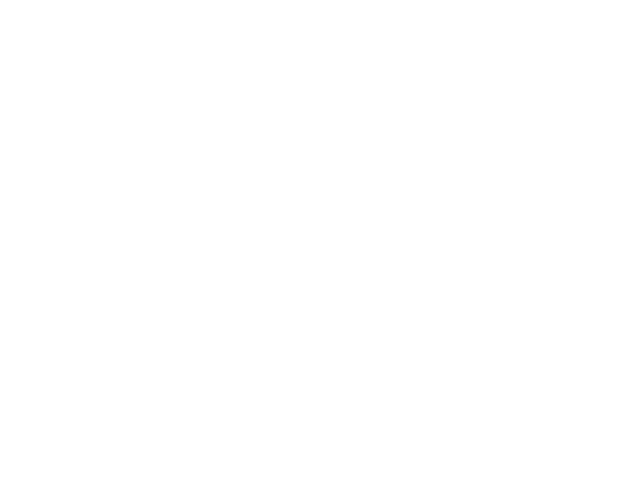

In [14]:
%matplotlib notebook
plt.scatter(xcoord, ycoord,c= 'yellowgreen', s= 20, label = 'Susceptible farms')
plt.scatter(CompleteData[CompleteData['fmd']==1]['xcoord'].values, CompleteData[CompleteData['fmd']==1]['ycoord'].values, s=10, c='r', label ='Infected farms')
plt.axis('scaled')
plt.xticks([],[])
plt.yticks([],[])
plt.legend(loc = 'upper left')

In [15]:
CompleteData.columns.values

array(['study', 'lat', 'long', 'cattle', 'sr', 'fmd', 'vaccine',
       'water_grazing', 'milk', 'equipment', 'vet', 'contact_animal',
       'contact_people', 'grazing', 'water', 'Easting', 'Northing',
       'xcoord', 'ycoord'], dtype=object)

# Determining Attribute weights for Infection

In [16]:
#We will produce a decision tree to determine the weight of each attribute a1-7.
equipment = CompleteData['equipment']
shares_water = CompleteData['water']
shares_grazing = CompleteData['grazing']
shares_milk = CompleteData['milk']
shares_vet = CompleteData['vet']
contact_animal = CompleteData['contact_animal']
contact_human = CompleteData['contact_people']
has_fmd = CompleteData['fmd']
inputs = pd.concat([equipment, shares_water, shares_grazing, shares_milk, shares_vet, contact_animal, contact_human], axis=1)
targets = has_fmd

In [17]:
#Set up the decision tree
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(inputs, targets)
fi = clf.feature_importances_
print(fi)

[0.16964086 0.16230848 0.1756672  0.06334324 0.13775076 0.13500596
 0.15628351]


# Set up for the UK model

In [18]:
cattle = CompleteData['cattle'].values
sheep = CompleteData['sr'].values
vac = CompleteData['vaccine'].values
wg = CompleteData['water_grazing'].values

In [19]:
#Parameter values
        
psi = 0.00657
nu = 1.99*(10**(-7))
xi = 4.65
zeta = 2.80
chi = 0.403
phi = 0.799
rho = 0.000863


# nu=5.1e-7
# xi=7.7e-7
# zeta=10.5
# chi=1
epsilon = 0.20 #Vaccine parameter
s = np.random.negative_binomial(50, 50/55, 342) #Draw latent periods
r = np.random.negative_binomial(30, 30/38, 342) #Draw infectious periods

#Calculate distance kernel
# K = psi/(psi**2 + dist**2)   

In [20]:
# Data driven kernel
kernelData=pd.read_csv(Path + 'Kernel',header=None,delim_whitespace=True)
kernelDist = kernelData.values[:,0]
kernelDist = kernelDist/100
kernelValue = kernelData.values[:,1]
zeroDistKernel = 1
roundDist = np.rint(dist*10)

K = np.zeros(shape=(N,N))
for i in range(len(roundDist)):
    for j in range(len(roundDist)):
        if (roundDist[i,j] != 0) & (roundDist[i,j] <= 599): #max 59.9km apart
            K[i,j] = kernelValue[int(roundDist[i,j])-1]
        elif roundDist[i,j] > 599:
            K[i,j] = 0
        elif roundDist[i,j] == 0:
            K[i,j] = kernelValue[0]

In [21]:
#Calculate susceptibility

beta1 = np.zeros(342)
beta1 = nu*(xi*(cattle)**chi + (sheep)**chi)

for i in range(0,342):
    if (CompleteData['vaccine'][i] == 1):
       beta1[i] = epsilon*beta1[i]

In [22]:
CompleteData.columns.values

array(['study', 'lat', 'long', 'cattle', 'sr', 'fmd', 'vaccine',
       'water_grazing', 'milk', 'equipment', 'vet', 'contact_animal',
       'contact_people', 'grazing', 'water', 'Easting', 'Northing',
       'xcoord', 'ycoord'], dtype=object)

# Below is the same model as for UK (cauchy) doesn't take into account other attributes

- does a bad job, none of the farms infect any other
- added in a different sero type being introduced into the environment every 1/4 of a year, did nothing

<IPython.core.display.Javascript object>


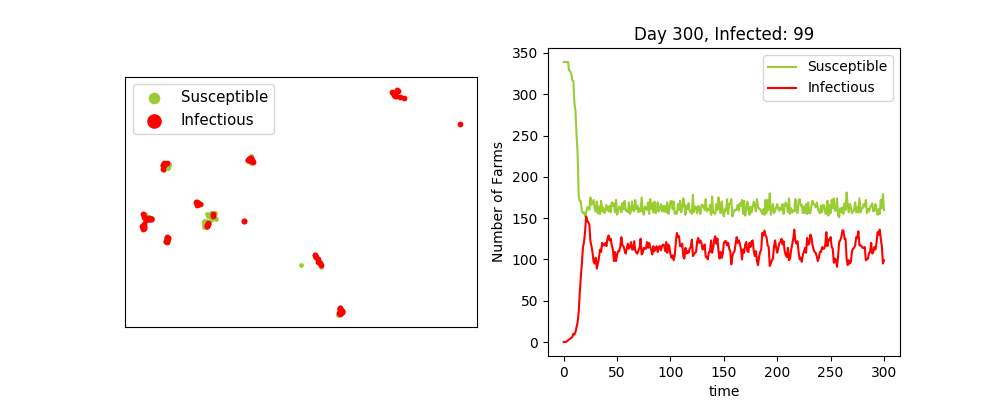

In [49]:
for i in range(1):
#Choose initial cases
       
    t = 0
    A = np.zeros(shape=(N,5)) 
    numInf = np.zeros(10000)  

    initial1 = random.randint(0,N)
    initial2 = initial1+1
    initial3 = initial2+1
    
    infect_cow = np.zeros(N)
    infect_sheep = np.zeros(N)
    I = np.zeros(N)
    
    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1
#     for rin in [initial1, initial2, initial3]:
#         if (random.random() < 0.5 and sheep[rin]>=1):
#             infect_sheep[rin]= 1
#         else:
#             infect_cow[rin] =1
    bet = []
    A[initial1, ] = [initial1, 0, s[initial1], r[initial1], vac[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2], vac[initial2]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3], vac[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
        ####### within farm infection ########
#         for farm in infectind:
#             Num_livestock = infect_cow[farm] + infect_sheep[farm]
#             λ = 0.1
#             inf = 1-((1-λ)**Num_livestock) #probability of infecting one animal
#             for animals in range(int(cattle[farm]+sheep[farm])):
#                 p_beta = np.random.uniform(0,1)
#                 if (p_beta<inf) and (infect_sheep[farm]+infect_cow[farm])<=Num_livestock:
#                     if (random.random() < 0.5 and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
#                         infect_sheep[farm] += 1
#                     elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
#                         infect_cow[farm] +=1
    

        
        
        ####### between farm infections #########
        numInf[t] = sum(I == 2)
        t = t + 1
        
        beta = np.zeros(N)
        beta2 = nu*(cattle)**chi + (sheep)**chi #all suscepitble animals
        for j in range(0,N):
            beta[j] = beta2[j]*(np.sum((nu*(cattle[I==2]**chi) +(sheep[I==2]**chi))*kerneldist[I==2, j]))

        #Calculate probability of infection
        prob_inf = (1 - np.exp(-beta)) #why is there a 5 here?
        bet.append(np.mean(beta))

        #Infect if probability is less that a uniform sample
        unif = np.random.uniform(0, 1, N)

        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
#                 su = sum(I != 0) #THIS DOESN'T WORK, WHAT IS ITS USE?
                A[i, ] = [i, t, s[i], r[i], vac[i]]

        ###### Update states #####
        ###### first remove animals ######

        inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
        I[inf.astype(np.int64)] = 2
        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
        A[rem.astype(np.int64), ] = [0,0,0,0,0]
        I[rem.astype(np.int64)] = 0
        
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]

        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        
        time_plot.append(t)


#         xlatentplot = xcoord[infectind]
#         ylatentplot = xcoord[]
        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
    
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()


<IPython.core.display.Javascript object>


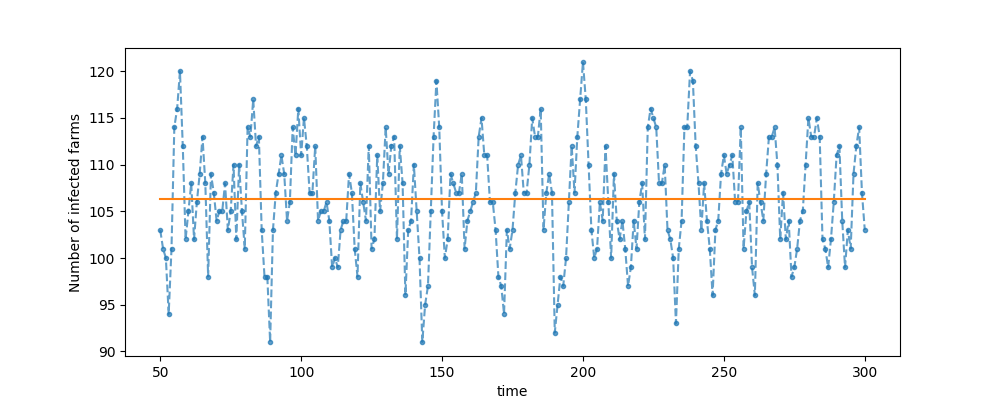

106.3187250996016

In [135]:
%matplotlib notebook
plt.figure(figsize = (10,4))
plt.plot(time_plot[50:], Inf[50:],'o--', ms = 3, alpha = 0.7, label = 'UK model')
plt.plot(time_plot[50:], np.mean(Inf[50:])*np.ones(len(Inf[50:])), label = 'mean - endemic state')
plt.xlabel('time')
plt.ylabel('Number of infected farms')
m = np.mean(Inf[50:])
m

# Below is the UK model but with within dynamics (metapopulation)

<IPython.core.display.Javascript object>


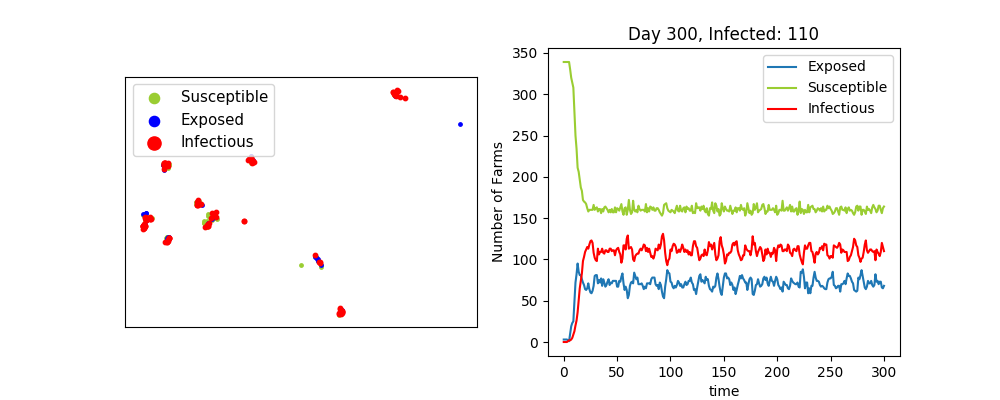

In [128]:
for i in range(1):
#Choose initial cases
       
    t = 0
    A = np.zeros(shape=(N,5))
#     output = np.zeros(shape=(1000,6))     
    numInf = np.zeros(10000)  

    initial1 = random.randint(0,N)
    initial2 = initial1+1
    initial3 = initial2+1
    I = np.zeros(N)
    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1
    A[initial1, ] = [initial1, 0, s[initial1], r[initial1], vac[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2], vac[initial2]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3], vac[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    exposedind = [i for i in range(np.size(I)) if I[i] ==1]
    infect_cow = np.zeros(N)
    infect_sheep = np.zeros(N)
    bet1 = []
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    Exp = [len(exposedind)]
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
     ####### within farm infection ########
        for farm in infectind:
            Num_livestock = infect_cow[farm] + infect_sheep[farm]
            λ = 0.1
            inf = 1-((1-λ)**Num_livestock) #probability of infecting one animal
            for animals in range(int(cattle[farm]+sheep[farm])):
                p_beta = np.random.uniform(0,1)
                if p_beta<inf:
                    if (random.random() < 0.5 and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
                        infect_sheep[farm] += 1
                    elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
#                         print('true')
                        infect_cow[farm] +=1
    

        
        numInf[t] = sum(I == 2)
        t = t + 1
        beta2 = nu*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi #all suscepitble animals
        beta = np.zeros(N)

        for j in range(0,N):
            beta[j] = beta2[j]*(np.sum((nu*(infect_cow[I==2]**chi) +(infect_sheep[I==2]**chi))*kerneldist[I==2, j]))
       
        #Calculate probability of infection
        prob_inf = (1 - np.exp(-beta)) #why is there a 5 here?
        bet1.append(np.mean(beta))

        #Infect if probability is less that a uniform sample
        unif = np.random.uniform(0, 1, N)

        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                A[i, ] = [i, t, s[i], r[i], vac[i]]
            
        #Update states
        ###### first remove animals ######

        inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
        I[inf.astype(np.int64)] = 2
        for i in inf: #add animals to the infected list
            i = int(i)
            if (random.random() < 0.5 and sheep[i]>=1 and infect_sheep[i]<sheep[i]):
                infect_sheep[i] += 1
            elif (cattle[i]>=1 and infect_cow[i]<cattle[i]):
                infect_cow[i] +=1
#                 print('cattle', cattle[i], 'cow', infect_cow[i])
        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
        infect_sheep[rem.astype(np.int64)] = 0
        infect_cow[rem.astype(np.int64)] = 0
        I[rem.astype(np.int64)] = 0
        
#         inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
#         I[inf.astype(np.int64)] = 2
#         rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
#         I[rem.astype(np.int64)] = 0
        
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]
        exposedind = [i for i in range(np.size(I)) if I[i] ==1]
        infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
        for farm in infected:
            mu = 0.05
            recover = np.random.uniform(0,1)
            for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
                if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
                    if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
                        infect_sheep[farm] -= 1
                    elif infect_cow[farm]>=1: 
                        infect_cow[farm] -= 1
                    if infect_sheep[farm]+infect_cow[farm] ==0: #farm has recovered before its end period
                        I[farm] = 0
        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        Exp.append(len(exposedind))
        time_plot.append(t)


        xexposedplot = xcoord[exposedind]
        yexposedplot = ycoord[exposedind]
        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
        ax1.plot(time_plot, Exp, label = 'Exposed')
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xexposedplot, yexposedplot, c ='b', marker = 'o', s=6, label = 'Exposed')
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()

# Add in additional interactions between farms, based on if they're less than 10km away and share: water, milk, grazing and equipment

In [ ]:
%matplotlib notebook
ψ = 2.5 #changed the distance kernel
plt.plot(range(80), [ψ/(ψ**2+x**2) for x in range(80)],label = 'cauchy' )
plt.plot(kernelDist/10, kernelValue, label = 'data driven')
plt.legend(loc = 'upper right')

# things
- found for every farm that said they shared equipment, milk, water, grazing, found all farms in a 10km euclidean distance from them and put a 1 - IS 10KM A GOOD GUESS?, (going off they wouldn't go more than 4km for water)
- did this for contact_animal and people but put no restriction as they can be at markets - SHOULD WE ADD A DISTANCE
- need to fit for a1-a7, assumed them all to be 1 for now (BAD ASSUMPTION)
- see if any attributes are correlated, reject them
- Then I multiplied each column (which corresponds to a farm j for all i, transmission_matrix[:,j]) by the number of livestock on that farm, with the $\nu$ and $\chi$ terms. So this matrix contains number of livestock on infected farms:

When we calculate


$\beta[j]$ = Number_livestock_on_j x Tranmission_matrix_row_j_all_infected_farms_column x
Kerneldist_distance_between_rows_of_all_infected_farms_and_column_j


In [24]:
rounddist =np.around(dist,decimals = 1)
kerneldist = 2.5/(2.5**2 + rounddist**2)

In [45]:
shares_equipment = np.zeros(shape = (N,N)) #cap at 10km
shares_water = np.zeros(shape = (N,N)) #cap at 10km
shares_grazing = np.zeros(shape=(N,N)) #cap at 10km
shares_milk = np.zeros(shape = (N,N)) #cap at 10km
shares_vet = np.zeros(shape = (N,N)) #cap at 10km
contactanimal = np.zeros(shape = (N,N))
contacthuman = np.zeros(shape = (N,N)) 


for i in range(N):
    for j in range(N):
        if i != j:
            if dist[i,j] <= 10:
                if (CompleteData['milk'][[i]].values==1 and CompleteData['milk'][[j]].values ==1):
                    shares_milk[i,j] = 1
                if (CompleteData['water'][[i]].values==1 and CompleteData['water'][[j]].values ==1):
                    shares_water[i,j] =1
                if (CompleteData['grazing'][[i]].values==1 and CompleteData['grazing'][[j]].values ==1):
                    shares_grazing[i,j] =1
                if (CompleteData['equipment'][[i]].values==1 and CompleteData['equipment'][[j]].values ==1):
                    shares_equipment[i,j] =1
                if (CompleteData['vet'][[i]].values==1 and CompleteData['vet'][[j]].values ==1):
                    shares_vet[i,j] = 1
            if (CompleteData['contact_animal'][[i]].values==1 and CompleteData['contact_animal'][[j]].values ==1):
                contactanimal[i,j] = 1
            if (CompleteData['contact_people'][[i]].values==1 and CompleteData['contact_people'][[j]].values ==1):
                contacthuman[i,j] = 1

In [46]:
CompleteData.columns.values
a1 = 1
a2 = 1
a3 = 1
a4 = 1
a5 =1 
a6 =1
a7 =1
transmission_matrix = (a1*shares_equipment+
 a2*shares_water+
 a3*shares_grazing + 
 a4*shares_milk + 
 a5*shares_vet + 
 a6*contactanimal + 
 a7*contacthuman)


# Actually get some SI spread (hits peak and then fluctuates)

<IPython.core.display.Javascript object>


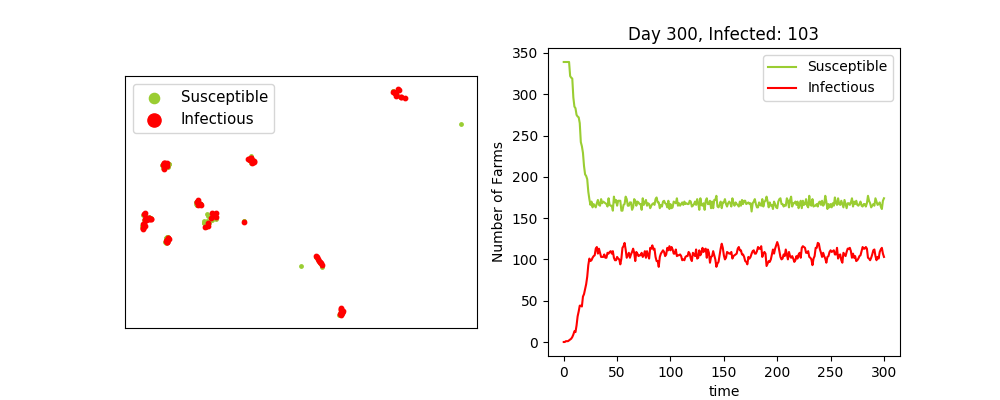

In [129]:
for i in range(1):
#Choose initial cases
       
    t = 0
    A = np.zeros(shape=(N,5)) 
    numInf = np.zeros(10000)  

    initial1 = random.randint(0,N)
    initial2 = initial1+1
    initial3 = initial2+1
    
    infect_cow = np.zeros(N)
    infect_sheep = np.zeros(N)
    I = np.zeros(N)
    bet2 = []
    I[initial1] = 1
    I[initial2] = 1
    I[initial3] = 1
#     for rin in [initial1, initial2, initial3]:
#         if (random.random() < 0.5 and sheep[rin]>=1):
#             infect_sheep[rin]= 1
#         else:
#             infect_cow[rin] =1
        
    A[initial1, ] = [initial1, 0, s[initial1], r[initial1], vac[initial1]]
    A[initial2, ] = [initial2, 0, s[initial2], r[initial2], vac[initial2]]
    A[initial3, ] = [initial3, 0, s[initial3], r[initial3], vac[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
        ####### within farm infection ########
        for farm in infectind:
            Num_livestock = infect_cow[farm] + infect_sheep[farm]
            λ = 0.1
            inf = 1-((1-λ)**Num_livestock) #probability of infecting one animal
            for animals in range(int(cattle[farm]+sheep[farm])):
                p_beta = np.random.uniform(0,1)
                if (p_beta<inf) and (infect_sheep[farm]+infect_cow[farm])<=Num_livestock:
                    if (random.random() < 0.5 and sheep[farm]>=1 and infect_sheep[farm]<sheep[farm]):
                        infect_sheep[farm] += 1
                    elif (cattle[farm]>=1 and infect_cow[farm]<cattle[farm]):
                        infect_cow[farm] +=1
    

        
        
        ####### between farm infections #########
        numInf[t] = sum(I == 2)
        t = t + 1
        transmission_matrix = (a1*shares_equipment+ #need to clear and update this everytime
        a2*shares_water+
        a3*shares_grazing + 
        a4*shares_milk + 
        a5*shares_vet + 
        a6*contactanimal + 
        a7*contacthuman)

        beta = np.zeros(N)
        beta2 = nu*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi #all suscepitble animals
        beta3 = nu*infect_cow**chi+infect_sheep**chi # all infected animals

        for i in range(N):
            transmission_matrix[:,i] *= (beta3)[i] #tranmission matrix is the infected ones
        

        for j in range(0,N):
            beta[j] = beta2[j]*np.matrix(transmission_matrix)[j,I==2]*np.matrix(kerneldist)[I == 2, j]

        #Calculate probability of infection
        prob_inf = (1 - np.exp(-beta)) #why is there a 5 here?
        
        bet2.append(np.mean(beta))
        #Infect if probability is less that a uniform sample
        unif = np.random.uniform(0, 1, N)

        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
#                 su = sum(I != 0) #THIS DOESN'T WORK, WHAT IS ITS USE?
                A[i, ] = [i, t, s[i], r[i], vac[i]]

        ###### Update states #####
        ###### first remove animals ######
        infected = [i for i in range(N) if (infect_cow+infect_sheep)[i]>0]
        for farm in infected:
            mu = 0.05
            recover = np.random.uniform(0,1)
            for animals in range(int(infect_cow[farm]+infect_sheep[farm])):
                if recover < mu and (infect_sheep[farm]+infect_cow[farm]) >=1 :
                    if (random.random() < 0.5 and infect_sheep[farm]>=1 ):
                        infect_sheep[farm] -= 1
                    elif infect_cow[farm]>=1: 
                        infect_cow[farm] -=1
                    if infect_sheep[farm]+infect_cow[farm] ==0: #farm has recovered before its end period
                        I[farm] = 0
        inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
        I[inf.astype(np.int64)] = 2
        for i in inf: #add animals to the infected list
            i = int(i)
            if (random.random() < 0.5 and sheep[i]>=1 and infect_sheep[i]<sheep[i]):
                infect_sheep[i] += 1
            elif (cattle[i]>=1 and infect_cow[i]<cattle[i]):
                infect_cow[i] +=1
        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
        infect_sheep[rem.astype(np.int64)] = 0
        infect_cow[rem.astype(np.int64)] = 0
        A[rem.astype(np.int64), ] = [0,0,0,0,0]
        I[rem.astype(np.int64)] = 0
        
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]

        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        
        time_plot.append(t)



        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
    
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()


<IPython.core.display.Javascript object>


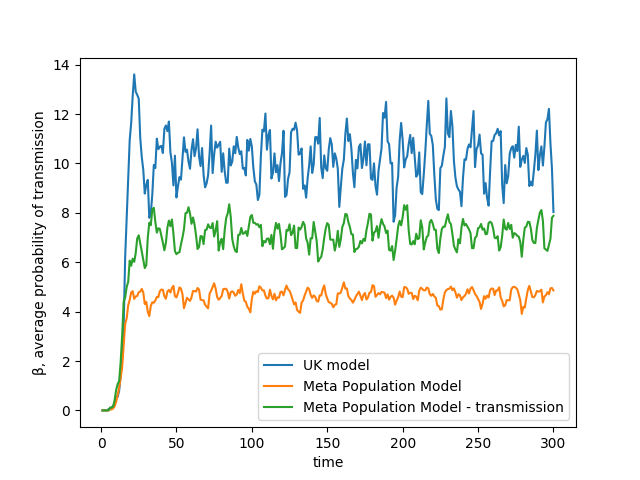

Text(0,0.5,'β, average probability of transmission')

In [132]:
%matplotlib notebook
plt.plot(time_plot[1:], bet, label = 'UK model')
plt.plot(time_plot[1:], bet1, label = 'Meta Population Model')
plt.plot(time_plot[1:], bet2, label = 'Meta Population Model - transmission')
plt.legend(loc = 'lower right')
plt.xlabel('time')
plt.ylabel('β, average probability of transmission')
# nu*(cattle-infect_cow)**chi + (sheep-infect_sheep)**chi #all suscepitble animals
# (cattle[0]-infect_cow[0])
# chi